## Projekt grupowy "Klasyfikacja rodzajów szkła"

Zespół 17:
Maria Mierzejewska, 
Karol Cieślik,
Jakub Matłacz

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

## 1. Wczytanie danych oryginalnych

In [184]:
glass_org = pd.read_csv('glass.csv')
glass_org

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Oznaczenia klas:<br>
-- 1 building windows float processed<br>
-- 2 building windows non float processed<br> 
-- 3 vehicle windows float processed<br>
-- 4 vehicle windows non float processed (none in this database)<br>
-- 5 containers<br>
-- 6 tableware<br>
-- 7 headlamps

## 2. Sprawdzenie braków danych

In [17]:
glass_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


## 3. Wykresy pudełkowe i skrzypcowe

In [18]:
def pokaz_pudelka(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.boxplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.boxplot(x="Type", y=atrybuty[i-2], data=glass)

In [19]:
def pokaz_skrzypce(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.violinplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.violinplot(x="Type", y=atrybuty[i-2], data=glass)

Obejrzymy teraz wykresy pudełkowe i skrzypcowe oryginalnych danych:

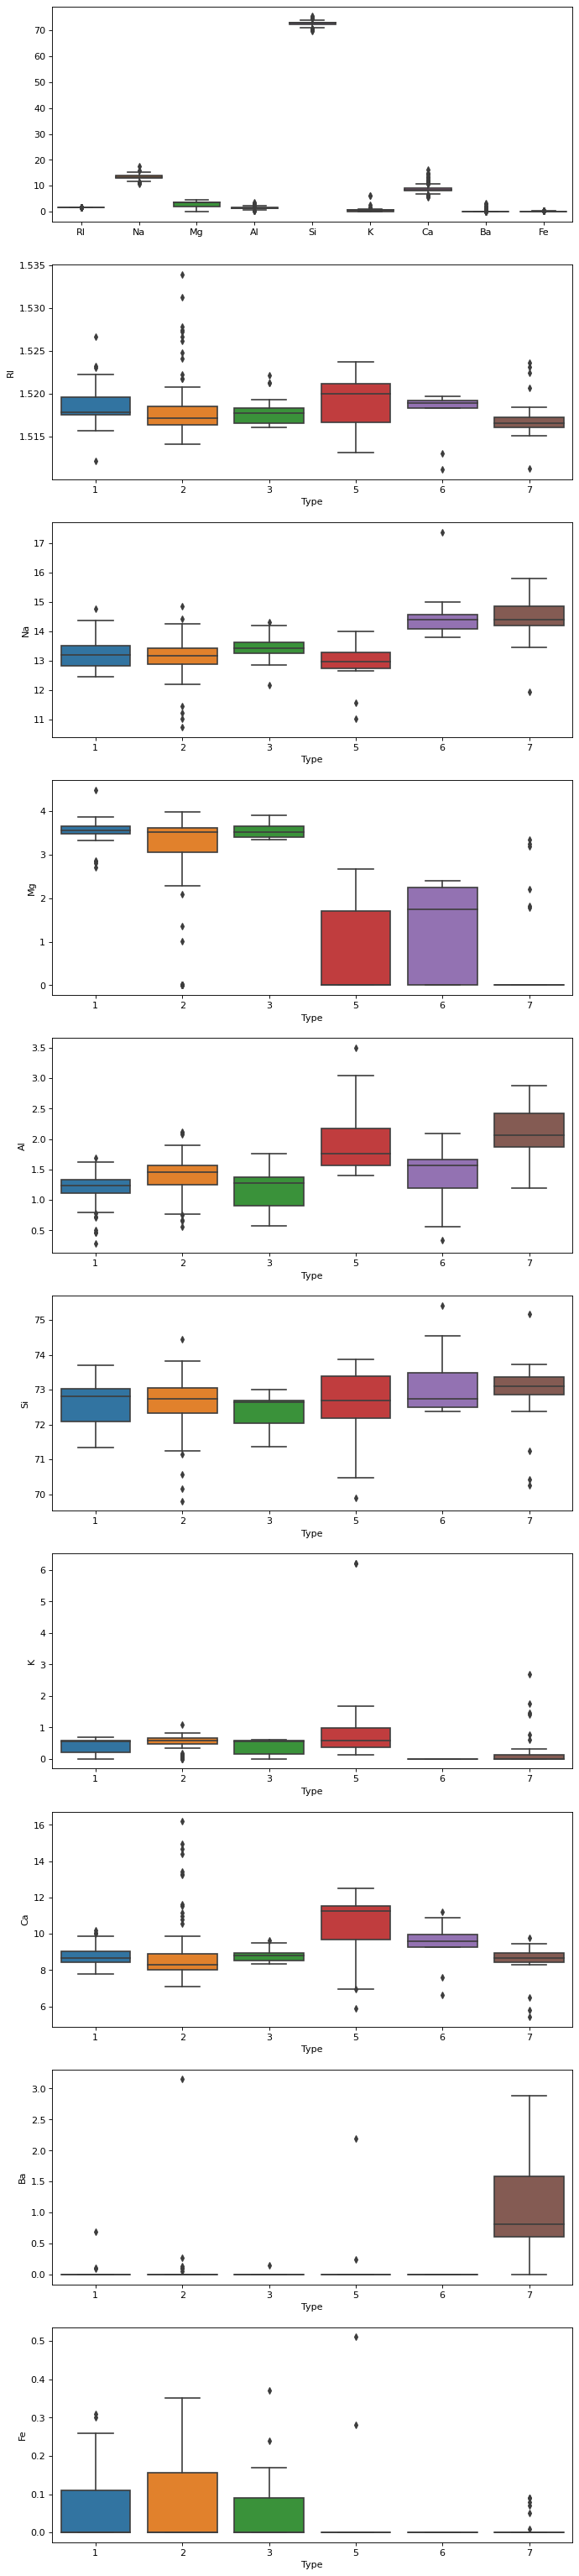

In [20]:
pokaz_pudelka(glass_org)

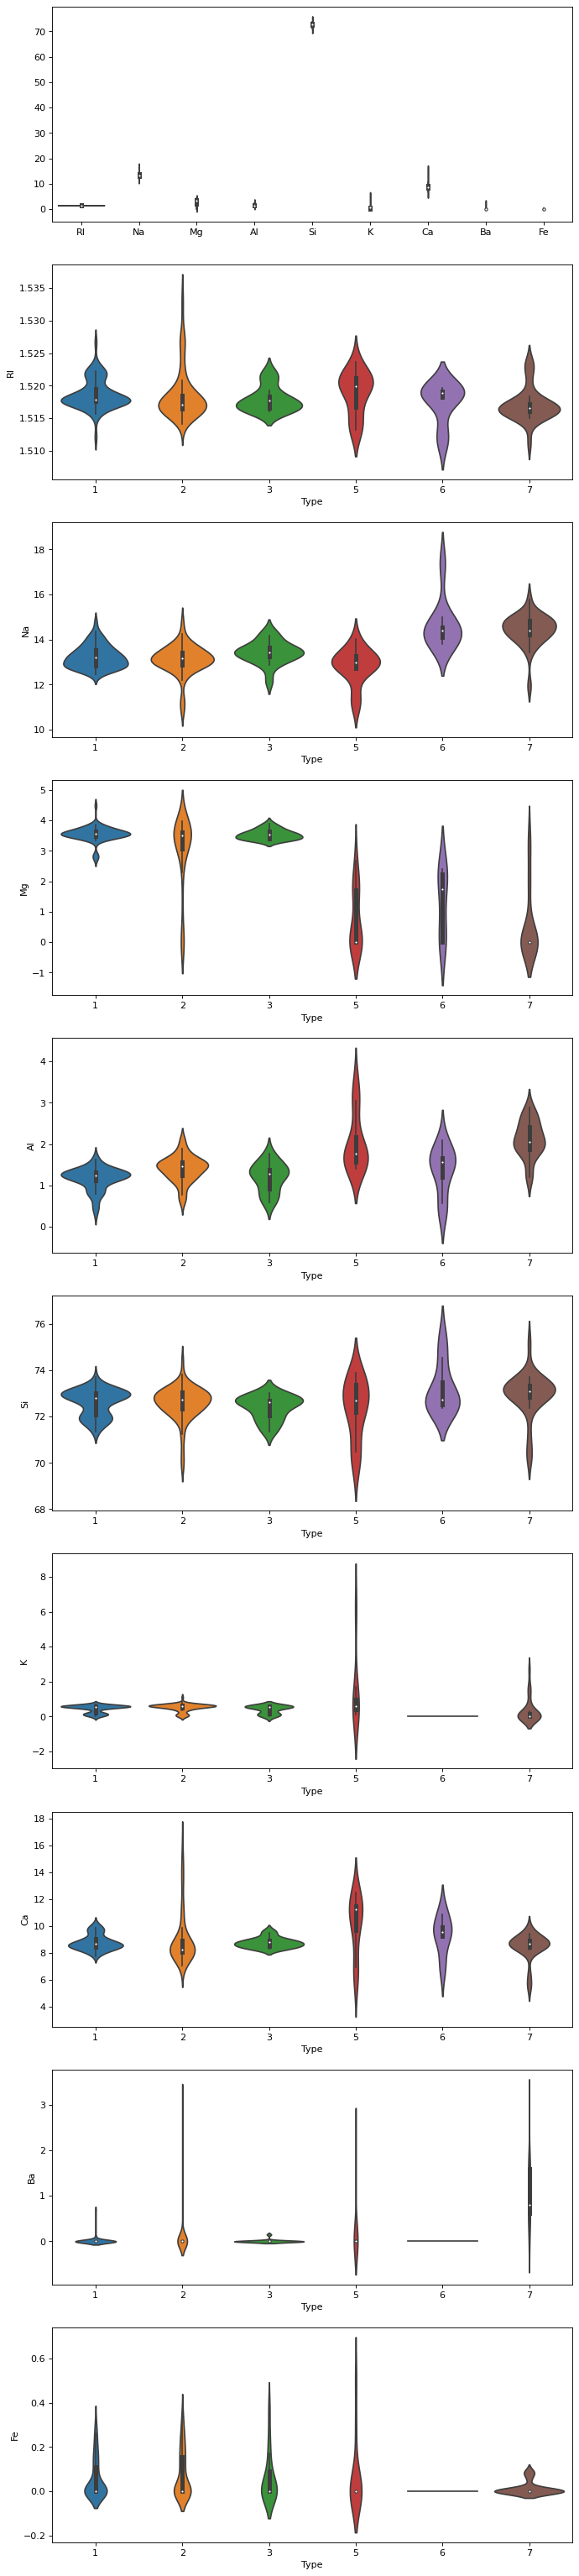

In [21]:
pokaz_skrzypce(glass_org)

## 4. Macierz korelacji oraz macierz wykresów punktowych

Macierz korelacji Pearsona w celu ewentualnej eliminacji zbędnych atrybutów:

Widać, że cecha Ca jest mocno skorelowana z cechą RI jednak nie wystarczająco, aby pominąć jedną z nich.

<AxesSubplot:>

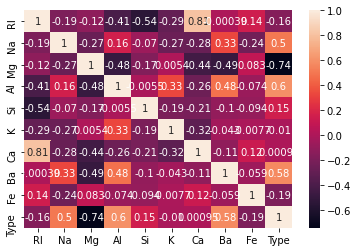

In [22]:
sns.heatmap(glass_org.corr(), annot = glass_org.corr())

Macierz wykresów punktowych w celu lepszej wizualizacji zbioru:

Widać, że cecha Ba może być dobrym wyznacznikiem przynależności obiektu do klasy 7. Wiele z histogramów przenika się w ogromnym stopniu.

In [ ]:
sns.pairplot(glass_org, kind="scatter", hue = "Type")

## 5. Oversampling oraz badanie dystrybucji klas  

In [55]:
def class_distr(glass):
    ile_ob_klas = []
    for i in range(1,8):
        ile_ob_klas.append(glass[glass.Type == i].shape[0])
    ile_ob_klas = pd.DataFrame(ile_ob_klas, index=range(1,8), columns=['ilość obiektów'])
    print(ile_ob_klas)
    ile_ob_klas.plot(kind='bar')

In [85]:
def podziel(df, proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(
        df.iloc[:,0:-1], df.iloc[:,-1], test_size=proporcja, random_state=3)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

   ilość obiektów
1              70
2              76
3              17
4               0
5              13
6               9
7              29


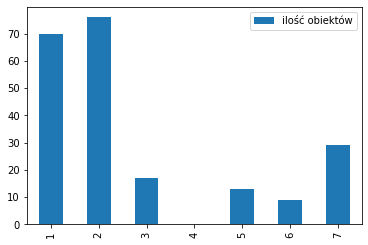

In [57]:
class_distr(glass_org)

Klasa 4 zostanie całkowicie pominięta w następujących rozważaniach i można ją traktować jako nieistniejącą. Z powodu braku jej próbek żaden obiekt nie będzie mógł zostać do niej przypisany.

Oryginalny zbiór jest niezbalansowany. Dzielimy go na część uczącą i testową. Pierwszą oversamplujemy (co jak widać na wykresie pozwoliło zbalansować zbiór uczący), a drugą zostawiamy i nie ruszamy tak, aby nie istniała część wspólna między zbiorem uczącym, a testowym (aby nasze wyniki nie były zakłamane).

In [93]:
glass_org_split = podziel(glass_org, 0.3)
x_learn = glass_org_split['opis_ucz']
y_learn = glass_org_split['dec_ucz']
x_test = glass_org_split['opis_test']
y_test = glass_org_split['dec_test']

In [30]:
sm = SMOTE(random_state=3)
x_learn_res, y_learn_res = sm.fit_resample(x_learn, y_learn)

Teraz obejrzyjmy wyniki podziału na część uczącą i testową:

   ilość obiektów
1              49
2              56
3              12
4               0
5               8
6               7
7              17


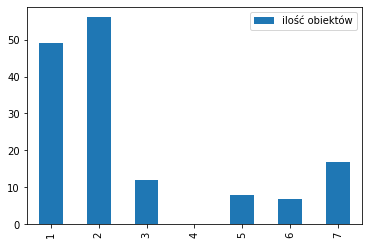

In [31]:
glass_learn = x_learn.copy()
glass_learn['Type'] = y_learn
class_distr(glass_learn)

   ilość obiektów
1              21
2              20
3               5
4               0
5               5
6               2
7              12


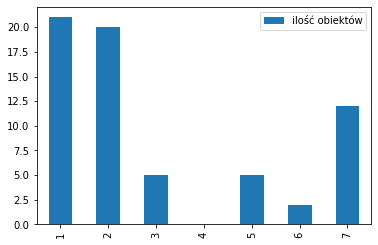

In [32]:
glass_test = x_test.copy()
glass_test['Type'] = y_test
class_distr(glass_test)

Dystrybucja klas w oversamplowanym zbiorzę uczącym:

   ilość obiektów
1              56
2              56
3              56
4               0
5              56
6              56
7              56


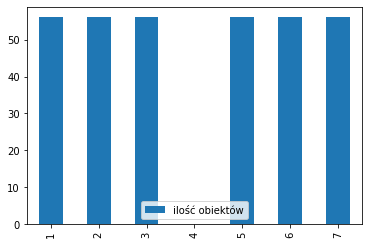

In [33]:
glass_learn_res = x_learn_res.copy()
glass_learn_res['Type'] = y_learn_res
class_distr(glass_learn_res)

## 6. Testowanie modeli

In [34]:
def weryfikuj(model):
    #pozwala sprawdzić z pomocą macierzy pomyłek jak działa dany model
    model.fit(x_learn_res, y_learn_res)
    
    wynik_ucz = model.predict(x_learn_res)
    wynik_test = model.predict(x_test)
    
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(y_learn_res, wynik_ucz)) 
    wyn_ucz = model.score(x_learn_res, y_learn_res)
    print("Blad uczenia ", 1-wyn_ucz)
    
    print("\nMacierz pomyłek dla zbioru testowego")
    print(pd.crosstab(y_test, wynik_test)) 
    wyn_test = model.score(x_test, y_test)
    print("Blad testowania ", 1-wyn_test)
    
    print("\nPrecyzja i czułość\n", metrics.classification_report(y_test, wynik_test, digits=2))

In [35]:
def wykres_bledu(max_k):
    #tworzy wykres bledu dla algorytmu kNN by wybrać najlepsze k
    wyniki = []
    for i in range(1,max_k+1):
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(x_learn_res, y_learn_res)
        wyn_test = 1-model.score(x_test, y_test)
        wyniki.append(wyn_test)
    kwart = pd.DataFrame(wyniki, index=range(1,max_k+1))
    plt.figure(dpi=90)
    plt.plot(kwart,'bo-')
    plt.title('Wykres bledu')
    plt.xlabel('Liczba sasiadow')
    plt.ylabel('Prawdopodobienstwo bledu')

Szukanie najlepszego k dla algorytmu kNN. Jak widać poniżej najlepsze wyniki mamy dla k=3:

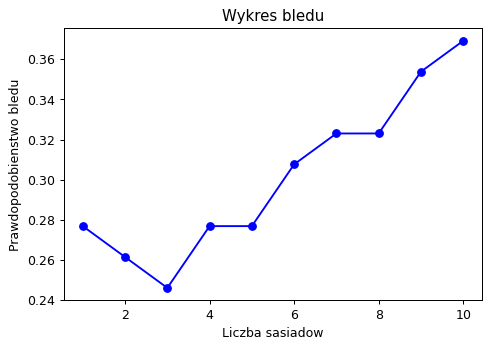

In [36]:
wykres_bledu(10)

> **KNeighborsClassifier**

Zaskakująco dobre wyniki tak prostego algorytmu uczenia leniwego. Wygląda na to, że nie ma ryzyka przetrenowania. Akceptowalny błąd zbioru testowego. Poza tym nie sprawdzam tylko błędu testowania gdyż zbiór testowy nie jest zbalansowany. Sprawdzam więc przede wszystkim precyzję i czułość.

In [37]:
model = KNeighborsClassifier(n_neighbors=3)
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      47   2   7   0   0   0
2       5  48   2   0   1   0
3       4   0  52   0   0   0
5       0   0   0  56   0   0
6       0   0   0   0  56   0
7       0   0   0   0   0  56
Blad uczenia  0.0625

Macierz pomyłek dla zbioru testowego
col_0   1   2  3  5  6   7
Type                      
1      16   2  3  0  0   0
2       1  14  2  0  3   0
3       1   0  4  0  0   0
5       0   0  0  4  0   1
6       0   0  0  1  1   0
7       1   0  0  0  1  10
Blad testowania  0.24615384615384617

Precyzja i czułość
               precision    recall  f1-score   support

           1       0.84      0.76      0.80        21
           2       0.88      0.70      0.78        20
           3       0.44      0.80      0.57         5
           5       0.80      0.80      0.80         5
           6       0.20      0.50      0.29         2
           7       0.91      0.83      0.87        12

    accurac

> **NearestCentroid**

Od razu widać duży błąd testowania oraz gorszą średnią czułość i precyzję.

In [38]:
model = NearestCentroid()
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0   1  2   3   5   6   7
Type                        
1      29  6  21   0   0   0
2      22  9  18   7   0   0
3      27  1  28   0   0   0
5       0  0   0  56   0   0
6       0  0   0   0  56   0
7       0  2   1   2   1  50
Blad uczenia  0.3214285714285714

Macierz pomyłek dla zbioru testowego
col_0   1  2  3  5  6  7
Type                    
1      13  1  7  0  0  0
2       9  2  5  3  1  0
3       0  1  4  0  0  0
5       0  1  0  4  0  0
6       0  0  0  1  1  0
7       0  0  2  0  1  9
Blad testowania  0.49230769230769234

Precyzja i czułość
               precision    recall  f1-score   support

           1       0.59      0.62      0.60        21
           2       0.40      0.10      0.16        20
           3       0.22      0.80      0.35         5
           5       0.50      0.80      0.62         5
           6       0.33      0.50      0.40         2
           7       1.00      0.75      0.86        12

    accuracy           

> **GaussianNB**

In [39]:
model = GaussianNB()
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0   1  2   3   5   6   7
Type                        
1      33  1  21   0   1   0
2      35  9   8   3   1   0
3       7  0  48   0   1   0
5       0  0   0  56   0   0
6       0  0   0   0  56   0
7       0  2   0   2   0  52
Blad uczenia  0.24404761904761907

Macierz pomyłek dla zbioru testowego
col_0   1  2  3  5  6   7
Type                     
1      15  1  5  0  0   0
2      12  2  2  2  2   0
3       2  0  3  0  0   0
5       0  0  0  4  0   1
6       0  0  0  0  2   0
7       1  0  0  0  0  11
Blad testowania  0.4307692307692308

Precyzja i czułość
               precision    recall  f1-score   support

           1       0.50      0.71      0.59        21
           2       0.67      0.10      0.17        20
           3       0.30      0.60      0.40         5
           5       0.67      0.80      0.73         5
           6       0.50      1.00      0.67         2
           7       0.92      0.92      0.92        12

    accuracy   

> **DecisionTreeClassifier**

In [40]:
model = tree.DecisionTreeClassifier(max_depth=4)
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      36   4  16   0   0   0
2      14  38   4   0   0   0
3       4   0  52   0   0   0
5       0   0   0  56   0   0
6       0   0   0   0  56   0
7       1   1   0   0   0  54
Blad uczenia  0.13095238095238093

Macierz pomyłek dla zbioru testowego
col_0   1   2  3  5  6   7
Type                      
1      11   5  5  0  0   0
2       5  10  2  2  1   0
3       1   1  3  0  0   0
5       1   2  0  2  0   0
6       0   0  0  0  2   0
7       1   0  1  0  0  10
Blad testowania  0.41538461538461535

Precyzja i czułość
               precision    recall  f1-score   support

           1       0.58      0.52      0.55        21
           2       0.56      0.50      0.53        20
           3       0.27      0.60      0.37         5
           5       0.50      0.40      0.44         5
           6       0.67      1.00      0.80         2
           7       1.00      0.83      0.91        12

Wygląda na to, że najlepszym modelem okazał się kNN dla k=3.

## 7. Walidacja krzyżowa

In [185]:
def podziel2(df, liczba):
    opis=[]
    dec=[]
    a=liczba
    for i in range (liczba-1):
        proporcja=1/a
        a=a-1
        opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(
            df.iloc[:,0:-1], df.iloc[:,-1], test_size=proporcja, random_state=3)
        df=opis_ucz.copy()
        df['Type']=dec_ucz
        opis.append(opis_test)
        dec.append(dec_test)
    opis.append(opis_ucz)
    dec.append(dec_ucz)
    return {"opis":opis, "dec":dec}

In [186]:
def połącz(dane):
    wynik=dane[0].copy()
    for i in (1, len(dane)-1):
        for j in range(dane[i].iloc[:,0].count()):
            wynik=wynik.append(dane[i].iloc[j,:])
    return wynik

In [187]:
glass_split = podziel2(glass_org, 4)
glass_split_opis = glass_split['opis']
glass_split_dec = glass_split['dec']
x_0 = glass_split_opis[0]
y_0 = glass_split_dec[0]
x_1 = glass_split_opis[1]
y_1 = glass_split_dec[1]
x_2 = glass_split_opis[2]
y_2 = glass_split_dec[2]
x_3 = glass_split_opis[3]
y_3 = glass_split_dec[3]

In [188]:
def weryfikuj2 (model):
    weryfikuj3(model, połącz([x_1, x_2, x_3]), y_1.append(y_2.append(y_3)), x_0, y_0, "0")
    weryfikuj3(model, połącz([x_0, x_2, x_3]), y_0.append(y_2.append(y_3)), x_1, y_1, "1")
    weryfikuj3(model, połącz([x_1, x_0, x_3]), y_1.append(y_0.append(y_3)), x_2, y_2, "2")
    weryfikuj3(model, połącz([x_1, x_2, x_0]), y_1.append(y_2.append(y_0)), x_3, y_3, "3")

def weryfikuj3(model, x_learn, y_learn, x_test, y_test, name=""):
    
    model.fit(x_learn, y_learn)
    wynik_test = model.predict(x_test)
    
    print("\nMacierz pomyłek dla zbioru testowego", name)
    print(pd.crosstab(y_test, wynik_test)) 
    wyn_test = model.score(x_test, y_test)
    print("Blad testowania ", 1-wyn_test)

> **KNeighborsClassifier**

In [191]:
model = KNeighborsClassifier(n_neighbors=3)
weryfikuj2(model)


Macierz pomyłek dla zbioru testowego 0
col_0   1   2  3  5  6  7
Type                     
1      12   3  2  0  0  0
2       2  11  0  1  2  0
3       4   0  1  0  0  0
5       0   1  0  4  0  0
6       0   1  0  0  0  0
7       0   1  0  0  1  8
Blad testowania  0.33333333333333337

Macierz pomyłek dla zbioru testowego 1
col_0   1   2  3  5  7
Type                  
1      13   2  4  0  0
2       7  16  1  0  0
3       3   0  1  0  0
5       0   0  0  2  0
7       1   0  0  0  4
Blad testowania  0.33333333333333337

Macierz pomyłek dla zbioru testowego 2
col_0   1   2  3  5  6  7
Type                     
1      16   2  0  0  0  0
2       3  13  0  0  0  0
3       1   0  3  0  0  0
5       0   1  0  1  0  0
6       0   0  0  0  2  1
7       0   1  0  1  0  8
Blad testowania  0.18867924528301883

Macierz pomyłek dla zbioru testowego 3
col_0  1   2  3  5  6  7
Type                    
1      9   4  3  0  0  0
2      7  12  0  0  1  0
3      1   2  1  0  0  0
5      0   1  0  3  0  0
6 

> **NearestCentroid**

In [192]:
model = NearestCentroid()
weryfikuj2(model)


Macierz pomyłek dla zbioru testowego 0
col_0   1  2  3  5  6  7
Type                    
1      12  1  4  0  0  0
2       9  1  2  2  2  0
3       2  1  2  0  0  0
5       0  0  0  4  0  1
6       0  0  0  0  1  0
7       0  0  1  0  1  8
Blad testowania  0.4814814814814815

Macierz pomyłek dla zbioru testowego 1
col_0   1  2  3  5  7
Type                 
1      11  4  4  0  0
2      11  1  9  3  0
3       3  0  1  0  0
5       0  0  0  2  0
7       0  0  0  0  5
Blad testowania  0.6296296296296297

Macierz pomyłek dla zbioru testowego 2
col_0   1  2  3  5  6  7
Type                    
1      11  1  6  0  0  0
2       6  3  5  1  1  0
3       0  0  4  0  0  0
5       0  0  0  2  0  0
6       0  1  0  0  1  1
7       0  0  0  1  1  8
Blad testowania  0.4528301886792453

Macierz pomyłek dla zbioru testowego 3
col_0   1  2  3  5  6  7
Type                    
1       8  2  6  0  0  0
2      13  4  1  2  0  0
3       3  0  1  0  0  0
5       0  0  0  4  0  0
6       0  2  0  1  2  0
7  

> **GaussianNB**

In [193]:
model = GaussianNB()
weryfikuj2(model)


Macierz pomyłek dla zbioru testowego 0
col_0   1  2  5  6   7
Type                  
1      16  1  0  0   0
2      11  1  2  2   0
3       5  0  0  0   0
5       0  1  3  0   1
6       0  0  0  1   0
7       0  0  0  0  10
Blad testowania  0.42592592592592593

Macierz pomyłek dla zbioru testowego 1
col_0   1  2  3  5  6  7
Type                    
1      13  0  5  0  1  0
2      17  2  2  1  1  1
3       3  0  1  0  0  0
5       0  1  0  1  0  0
7       0  0  0  0  0  5
Blad testowania  0.5925925925925926

Macierz pomyłek dla zbioru testowego 2
col_0  1  2   3  5  6  7
Type                    
1      0  1  17  0  0  0
2      0  5  10  1  0  0
3      1  0   2  0  1  0
5      0  2   0  0  0  0
6      0  0   0  0  3  0
7      0  0   0  1  0  9
Blad testowania  0.6415094339622642

Macierz pomyłek dla zbioru testowego 3
col_0   1  2  3  5  6  7
Type                    
1      10  3  3  0  0  0
2      14  5  0  1  0  0
3       3  0  1  0  0  0
5       0  2  0  2  0  0
6       0  0  0  0  5 

> **DecisionTreeClassifier**

In [194]:
model = tree.DecisionTreeClassifier(max_depth=4)
weryfikuj2(model)


Macierz pomyłek dla zbioru testowego 0
col_0   1   2  3  5  6   7
Type                      
1      15   0  1  0  0   1
2       3  10  0  2  1   0
3       2   1  2  0  0   0
5       0   0  0  3  1   1
6       0   0  0  0  1   0
7       0   0  0  0  0  10
Blad testowania  0.2407407407407407

Macierz pomyłek dla zbioru testowego 1
col_0   1   2  3  5  7
Type                  
1      15   3  1  0  0
2       4  16  3  1  0
3       2   0  2  0  0
5       0   0  0  2  0
7       0   1  0  0  4
Blad testowania  0.2777777777777778

Macierz pomyłek dla zbioru testowego 2
col_0   1  2  3  5  6  7
Type                    
1      17  1  0  0  0  0
2       8  8  0  0  0  0
3       2  1  1  0  0  0
5       0  0  0  2  0  0
6       0  2  0  0  1  0
7       0  1  0  0  1  8
Blad testowania  0.30188679245283023

Macierz pomyłek dla zbioru testowego 3
col_0   1   2  5  6  7
Type                  
1      11   5  0  0  0
2       6  13  0  1  0
3       2   2  0  0  0
5       0   0  3  1  0
6       1   1  0

Wyniki sprawdzianu krzyżowego sugerują, że najbardziej pasujące są modele kNN (k=3) i DecisionTree (depth=4), przy czym DecisionTree daje tutaj nawet lepsze wyniki niż kNN.